# **Wildfire Prediction Project**
This project aims to predict wildfire occurrences and sizes based on weather data and geospatial attributes. The workflow includes data loading, cleaning, merging, exploratory analysis, feature engineering, and model training.

## **Structure**
1. **Data Loading and Initial Cleaning**:
   - Load the datasets.
   - Perform initial cleaning (e.g., handle missing values, align data formats).

2. **Merging Datasets**:
   - Combine weather readings, station details, and wildfire data based on spatial and temporal keys.

3. **Exploratory Data Analysis (EDA)**:
   - Visualize the relationships between weather patterns and wildfire characteristics.

4. **Feature Engineering**:
   - Create new features to improve predictive accuracy.

5. **Model Training and Evaluation**:
   - Train machine learning models and evaluate their performance.

6. **Save Outputs**:
   - Save the final cleaned data, models, and evaluation results.

---

## **Section 1: Data Loading and Initial Cleaning**
This section involves:
- Loading the wildfire, weather readings, and weather station datasets.
- Dropping unnecessary columns.
- Handling missing values.
- Aligning data formats.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Import required libraries
import pandas as pd
import numpy as np

# Load datasets (replace file paths with actual locations)
weather_stations = pd.read_csv('/content/drive/Shareddrives/ENG M 680 - New/Project/Wildfire data/processed_weather_stations.csv')
wildfire_df = pd.read_csv('/content/drive/Shareddrives/ENG M 680 - New/Project/Wildfire data/processed_wildfire_df.csv')
weather_readings = pd.read_csv('/content/drive/Shareddrives/ENG M 680 - New/Project/Wildfire data/weather_readings.csv')


# Display basic information and initial rows for each dataset
print("Wildfire Dataset Overview:")
print(wildfire_df.info())
print(wildfire_df.head(), "\n")

print("Weather Readings Dataset Overview:")
print(weather_readings.info())
print(weather_readings.head(), "\n")

print("Weather Stations Dataset Overview:")
print(weather_stations.info())
print(weather_stations.head(), "\n")


Wildfire Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33149 entries, 0 to 33148
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    33149 non-null  int64  
 1   id                            33149 non-null  int64  
 2   fire_number                   33149 non-null  object 
 3   year                          33149 non-null  int64  
 4   discovered_date               30159 non-null  object 
 5   date                          33149 non-null  object 
 6   detection_agent_type          33149 non-null  object 
 7   smoke_type                    12599 non-null  object 
 8   smoke_color                   12849 non-null  object 
 9   smoke_base_size               12115 non-null  object 
 10  condition_of_smoke            8054 non-null   object 
 11  latitude                      33149 non-null  float64
 12  longitude                     331

Step 3: Data Insights
1. Wildfire Dataset
Overview:

Contains 33,149 entries with 61 columns.
Represents wildfire incidents, including details such as:
Spatial attributes: latitude, longitude.
Temporal attributes: date, discovered_date.
Fire attributes: fire_type, current_size, size_class.
Regional attributes: FA_NAME, forest_area.
Includes operational data like dispatch_date, assessment_size, and contained_size_obj.
Missing Data:

Significant gaps in attributes like smoke_type, smoke_color, and smoke_base_size.
Temporal columns (dispatch_date, ia_access, air_ff_start_date) and operational details have many missing values.
Columns FA_NAME and forest_area have minor missing values but are crucial for regional analysis.
2. Weather Readings Dataset
Overview:

Contains 1,048,575 entries with 21 columns.
Provides weather metrics recorded at different times and locations:
Temperature (dry_bulb_temperature), humidity (relative_humidity), and wind-related metrics (wind_speed_kmh).
Fire weather indices: ffmc, dmc, dc, isi, bui, fwi.
Associated with weather stations via station_id and temporally via date.
Missing Data:

High proportions of missing data in:
wind_gust_kmh (84% missing).
Fire weather indices (ffmc, dmc, dc, etc.) — ~30% missing.
Some missing values in critical features like dew_point and relative_humidity.
update_timestamp has limited utility for the analysis.
3. Weather Stations Dataset
Overview:

Contains 486 entries with 12 columns.
Metadata for weather stations:
Location: station_id, latitude, longitude, elevation_meters.
Ecological and regional details: natural_subregion, forest_area.
Missing Data:

Minimal missing data in natural_subregion (2 entries missing).

In [3]:
# Step 1: Add Latitude and Longitude to Weather Readings
# Merge Weather Readings with Weather Stations
updated_weather_readings = weather_readings.merge(
    weather_stations[['station_id', 'latitude', 'longitude']],
    on='station_id',
    how='left'
)

# Step 2: Check for Missing Latitude/Longitude After Merge
print("Checking for missing latitude/longitude in updated_weather_readings:")
print(updated_weather_readings[['latitude', 'longitude']].isnull().sum())

# Step 3: Handle Missing Latitude/Longitude
# If any rows are missing latitude or longitude after the merge, drop them
updated_weather_readings = updated_weather_readings.dropna(subset=['latitude', 'longitude'])

# Step 4: Round Latitude and Longitude
updated_weather_readings['latitude'] = updated_weather_readings['latitude'].round(2)
updated_weather_readings['longitude'] = updated_weather_readings['longitude'].round(2)

# Step 5: Output the Cleaned Data
print("Cleaned Weather Readings Dataset:")
print(updated_weather_readings.info())
print(updated_weather_readings.head())


Checking for missing latitude/longitude in updated_weather_readings:
latitude     0
longitude    0
dtype: int64
Cleaned Weather Readings Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 23 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Unnamed: 0            1048575 non-null  int64  
 1   station_id            1048575 non-null  object 
 2   date                  1048575 non-null  object 
 3   update_timestamp      63881 non-null    object 
 4   dry_bulb_temperature  1048574 non-null  float64
 5   dew_point             1034286 non-null  float64
 6   relative_humidity     1034484 non-null  float64
 7   rain_mm               1048575 non-null  float64
 8   snow_cm               1048575 non-null  float64
 9   hail_mm               1048575 non-null  float64
 10  precipitation_mm      1048575 non-null  float64
 11  wind_speed_kmh        1048569 non-null  float64

In [4]:
# Merge Wildfire Dataset with Weather Readings Dataset
# We assume 'date', 'latitude', and 'longitude' are the common keys for merging
merged_wildfire_weather = wildfire_df.merge(
    updated_weather_readings,
    on=['date', 'latitude', 'longitude'],  # Adjust keys if necessary
    how='inner'
)

# Output merged dataset information
print("Merged Wildfire-Weather Dataset:")
print(merged_wildfire_weather.info())
print(merged_wildfire_weather.head())

# Save the merged dataset for future use
output_file_path = '/content/drive/Shareddrives/ENG M 680 - New/Project/Wildfire data/merged_wildfire_weather_data.csv'
merged_wildfire_weather.to_csv(output_file_path, index=False)
print(f"Merged dataset saved to: {output_file_path}")


Merged Wildfire-Weather Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 81 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0_x                  0 non-null      int64  
 1   id                            0 non-null      int64  
 2   fire_number                   0 non-null      object 
 3   year                          0 non-null      int64  
 4   discovered_date               0 non-null      object 
 5   date                          0 non-null      object 
 6   detection_agent_type          0 non-null      object 
 7   smoke_type                    0 non-null      object 
 8   smoke_color                   0 non-null      object 
 9   smoke_base_size               0 non-null      object 
 10  condition_of_smoke            0 non-null      object 
 11  latitude                      0 non-null      float64
 12  longitude                     0 non-null   

In [7]:
# Step 1: Compare Date Ranges
print("Date range in Wildfire Dataset:", wildfire_df['date'].min(), "-", wildfire_df['date'].max())
print("Date range in Weather Readings Dataset:", updated_weather_readings['date'].min(), "-", updated_weather_readings['date'].max())

# Step 2: Compare Latitude and Longitude Ranges
print("Latitude range in Wildfire Dataset:", wildfire_df['latitude'].min(), "-", wildfire_df['latitude'].max())
print("Latitude range in Weather Readings Dataset:", updated_weather_readings['latitude'].min(), "-", updated_weather_readings['latitude'].max())

print("Longitude range in Wildfire Dataset:", wildfire_df['longitude'].min(), "-", wildfire_df['longitude'].max())
print("Longitude range in Weather Readings Dataset:", updated_weather_readings['longitude'].min(), "-", updated_weather_readings['longitude'].max())

# Step 3: Adjust Merge Criteria
# Match within a proximity range for spatial data and within the same day for temporal data
from datetime import timedelta

# Convert 'date' columns to datetime format
wildfire_df['date'] = pd.to_datetime(wildfire_df['date'], errors='coerce')
updated_weather_readings['date'] = pd.to_datetime(updated_weather_readings['date'], errors='coerce')

# Create new columns for day-based matching
wildfire_df['date_day'] = wildfire_df['date'].dt.date
updated_weather_readings['date_day'] = updated_weather_readings['date'].dt.date

# Perform a merge based on date (day) and proximity in latitude/longitude
merged_wildfire_weather = wildfire_df.merge(
    updated_weather_readings,
    on=['date_day'],  # Match on same day
    how='inner',
    suffixes=('_wildfire', '_weather')
)

# Filter merged dataset for proximity in latitude/longitude
proximity_threshold = 0.1  # Adjust as needed
merged_wildfire_weather = merged_wildfire_weather[
    (abs(merged_wildfire_weather['latitude_wildfire'] - merged_wildfire_weather['latitude_weather']) <= proximity_threshold) &
    (abs(merged_wildfire_weather['longitude_wildfire'] - merged_wildfire_weather['longitude_weather']) <= proximity_threshold)
]

# Step 4: Output Results
print("Merged Wildfire-Weather Dataset After Refinement:")
print(merged_wildfire_weather.info())
print(merged_wildfire_weather.head())

# Save the refined merged dataset
output_file_path = '/content/drive/Shareddrives/ENG M 680 - New/Project/Wildfire data/merged_wildfire_weather_data_refined.csv'
merged_wildfire_weather.to_csv(output_file_path, index=False)
print(f"Refined merged dataset saved to: {output_file_path}")


Date range in Wildfire Dataset: 1/1/1999 0:01 - 9/9/2017 10:14
Date range in Weather Readings Dataset: 1/1/1982 - 9/9/2020
Latitude range in Wildfire Dataset: 48.998195 - 59.99951
Latitude range in Weather Readings Dataset: 49.03 - 59.91
Longitude range in Wildfire Dataset: -120.0128 - -110.0002
Longitude range in Weather Readings Dataset: -120.01 - -110.17
Merged Wildfire-Weather Dataset After Refinement:
<class 'pandas.core.frame.DataFrame'>
Index: 3505 entries, 1145 to 3526320
Data columns (total 85 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Unnamed: 0_wildfire           3505 non-null   int64         
 1   id                            3505 non-null   int64         
 2   fire_number                   3505 non-null   object        
 3   year                          3505 non-null   int64         
 4   discovered_date               3215 non-null   object        
 5   date_wildfire  

In [8]:
# Step 1: Aggregate Weather Readings by Day and Station
aggregated_weather_readings = updated_weather_readings.groupby(
    ['station_id', 'date_day'], as_index=False
).agg({
    'dry_bulb_temperature': 'mean',
    'dew_point': 'mean',
    'relative_humidity': 'mean',
    'rain_mm': 'sum',
    'snow_cm': 'sum',
    'hail_mm': 'sum',
    'precipitation_mm': 'sum',
    'wind_speed_kmh': 'mean',
    'wind_gust_kmh': 'max',
    'ffmc': 'mean',
    'dmc': 'mean',
    'dc': 'mean',
    'isi': 'mean',
    'bui': 'mean',
    'fwi': 'mean',
    'dsr': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
})

print("Aggregated Weather Readings:")
print(aggregated_weather_readings.info())
print(aggregated_weather_readings.head())

# Step 2: Expand Spatial and Temporal Matching Criteria
# Add a buffer of ±0.5 degrees for latitude and longitude and ±1 day for date
merged_wildfire_weather = wildfire_df.merge(
    aggregated_weather_readings,
    on=['date_day'],  # Match only on date_day first
    how='inner',
    suffixes=('_wildfire', '_weather')
)

# Filter based on spatial proximity (±0.5 degrees)
proximity_threshold = 0.5
merged_wildfire_weather = merged_wildfire_weather[
    (abs(merged_wildfire_weather['latitude_wildfire'] - merged_wildfire_weather['latitude_weather']) <= proximity_threshold) &
    (abs(merged_wildfire_weather['longitude_wildfire'] - merged_wildfire_weather['longitude_weather']) <= proximity_threshold)
]

# Step 3: Output Results
print("Merged Wildfire-Weather Dataset with Expanded Criteria:")
print(merged_wildfire_weather.info())
print(merged_wildfire_weather.head())

# Save the refined merged dataset
output_file_path = '/content/drive/Shareddrives/ENG M 680 - New/Project/Wildfire data/merged_wildfire_weather_data_expanded.csv'
merged_wildfire_weather.to_csv(output_file_path, index=False)
print(f"Expanded merged dataset saved to: {output_file_path}")


Aggregated Weather Readings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   station_id            1048575 non-null  object 
 1   date_day              1048575 non-null  object 
 2   dry_bulb_temperature  1048574 non-null  float64
 3   dew_point             1034286 non-null  float64
 4   relative_humidity     1034484 non-null  float64
 5   rain_mm               1048575 non-null  float64
 6   snow_cm               1048575 non-null  float64
 7   hail_mm               1048575 non-null  float64
 8   precipitation_mm      1048575 non-null  float64
 9   wind_speed_kmh        1048569 non-null  float64
 10  wind_gust_kmh         159092 non-null   float64
 11  ffmc                  726270 non-null   float64
 12  dmc                   726269 non-null   float64
 13  dc                    726270 non-null   float64
 14  isi  

<ipython-input-9-14ef10b302d3>:7: DtypeWarning: Columns (10,18,19,26,34,35,36,38,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(file_path, parse_dates=['date', 'discovered_date'])


Merged dataset loaded successfully!


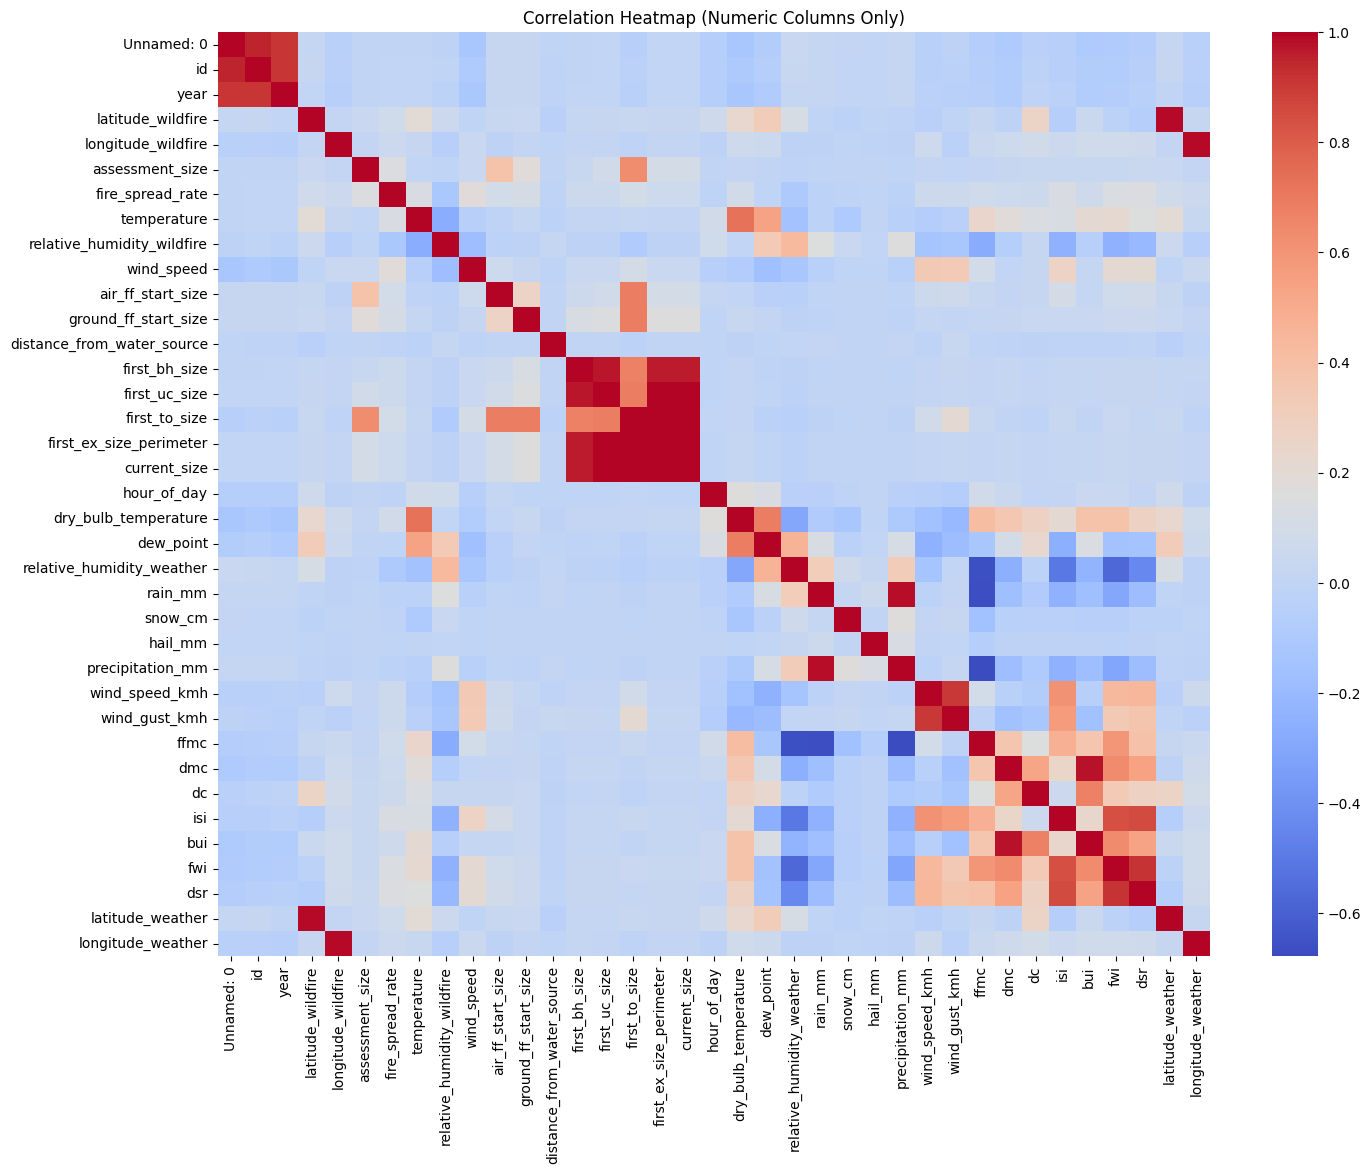

Summary Statistics for Numerical Columns:
         Unnamed: 0             id          year  latitude_wildfire  \
count  58407.000000   58407.000000  58407.000000       58407.000000   
mean   16272.887496   41169.957197   2005.064821          54.911356   
std     9493.250054   23174.895172      8.457010           2.333736   
min        0.000000       3.000000   1990.000000          48.998195   
25%     8210.000000   23394.000000   1998.000000          53.397300   
50%    16262.000000   36379.000000   2006.000000          55.222900   
75%    24480.000000   57252.500000   2012.000000          56.563650   
max    33148.000000  100065.000000   2020.000000          59.999400   

       longitude_wildfire  assessment_size  fire_spread_rate   temperature  \
count        58407.000000     58407.000000      48143.000000  33623.000000   
mean          -115.259926         1.850951          0.952095     18.713033   
std              2.250736        34.633992          3.054772      6.624380   
min   

In [9]:
import pandas as pd

# Update the file path to your merged dataset
file_path = '/content/drive/Shareddrives/ENG M 680 - New/Project/Wildfire data/merged_wildfire_weather_data_expanded.csv'

# Load the dataset
merged_df = pd.read_csv(file_path, parse_dates=['date', 'discovered_date'])
print("Merged dataset loaded successfully!")

# Filter for numeric columns only
numeric_columns = merged_df.select_dtypes(include=["float64", "int64"]).columns
correlation_data = merged_df[numeric_columns].corr()

# Plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_data, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

# Basic Statistics for numeric columns
print("Summary Statistics for Numerical Columns:")
print(merged_df[numeric_columns].describe())

print("Column Data Types:")
print(merged_df.dtypes)



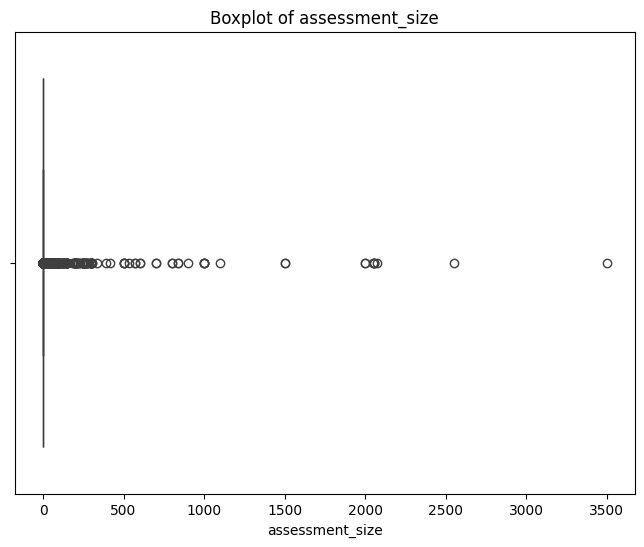

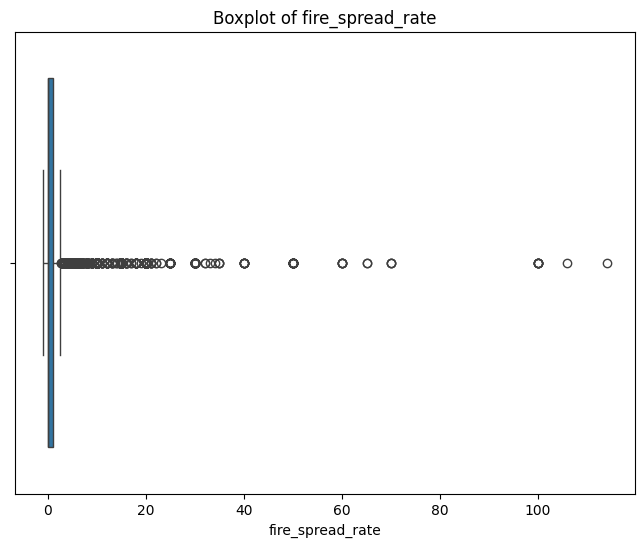

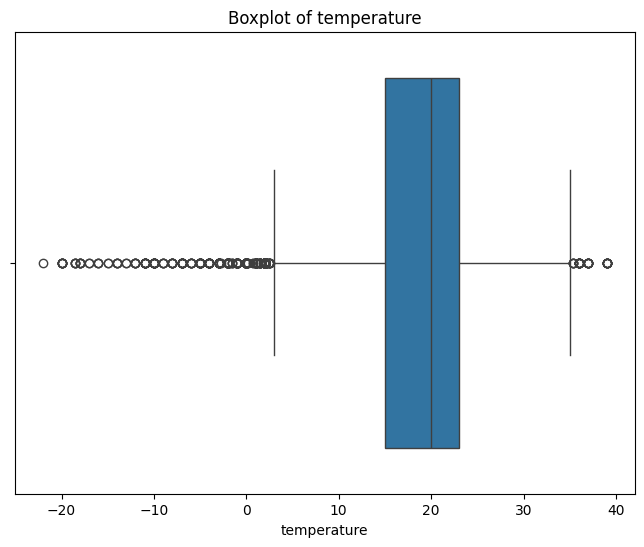

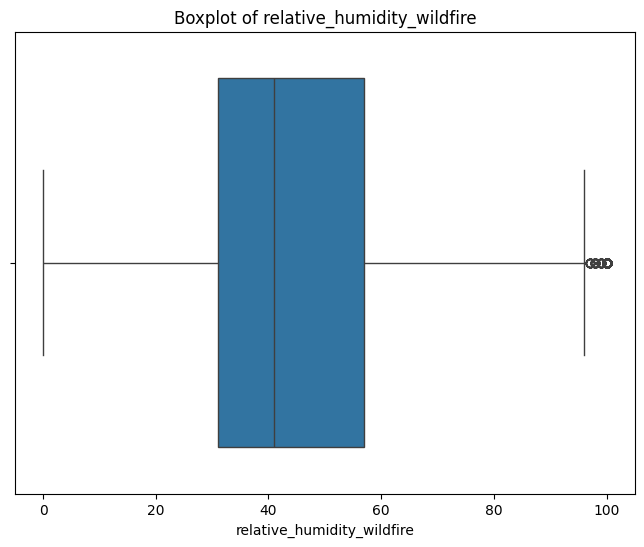

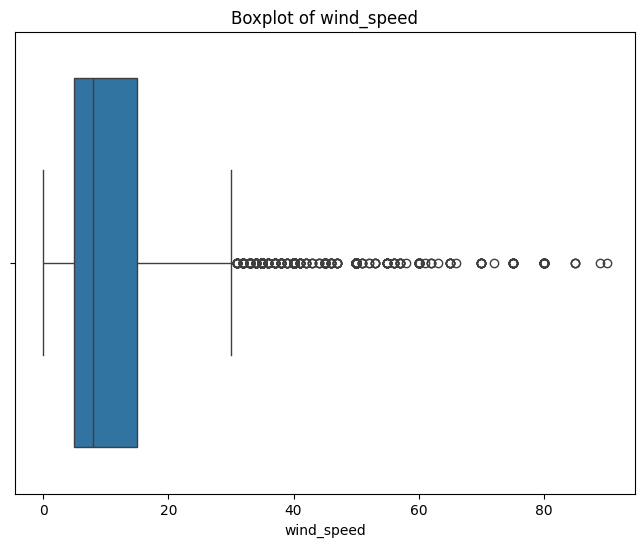

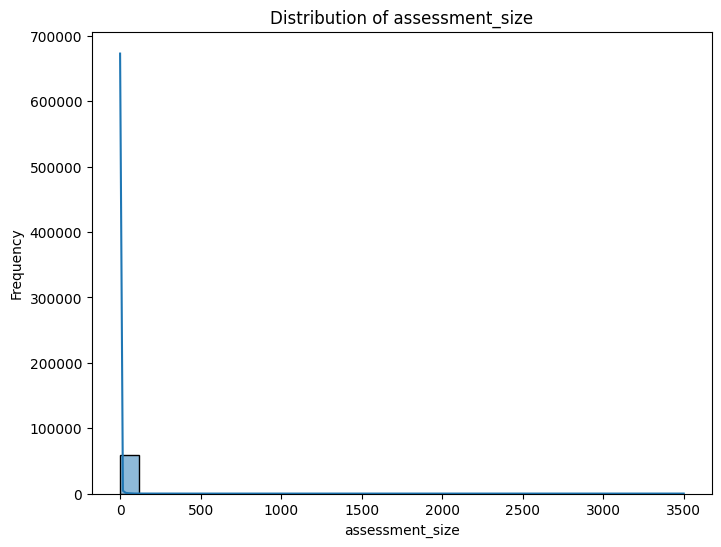

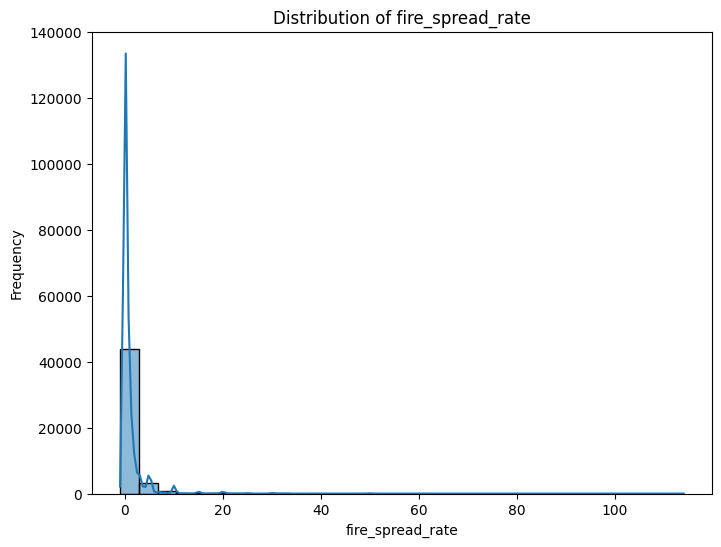

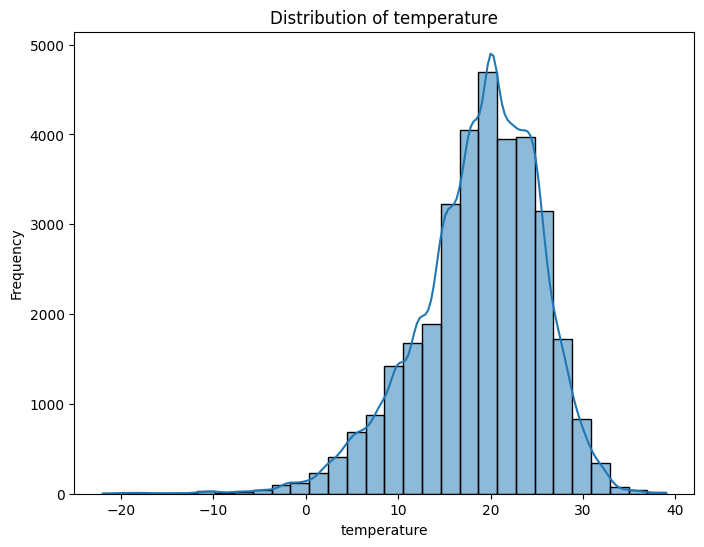

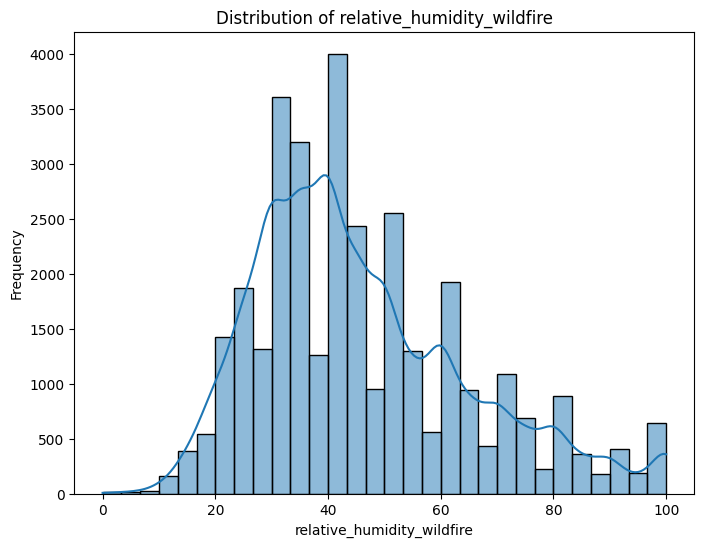

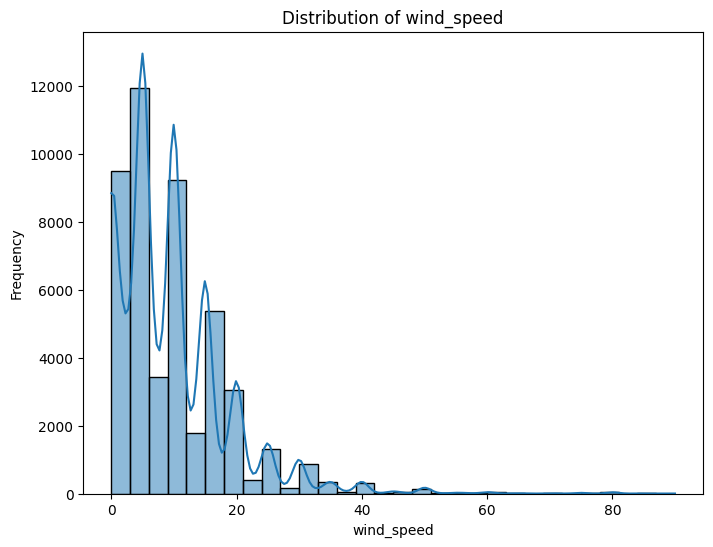

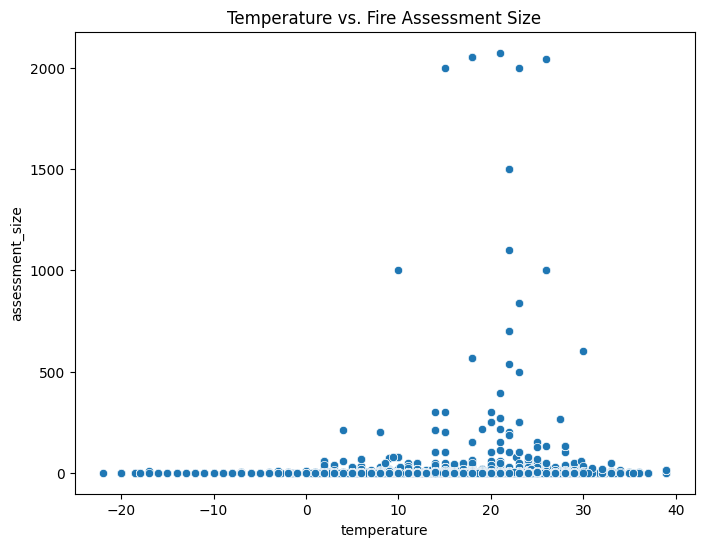

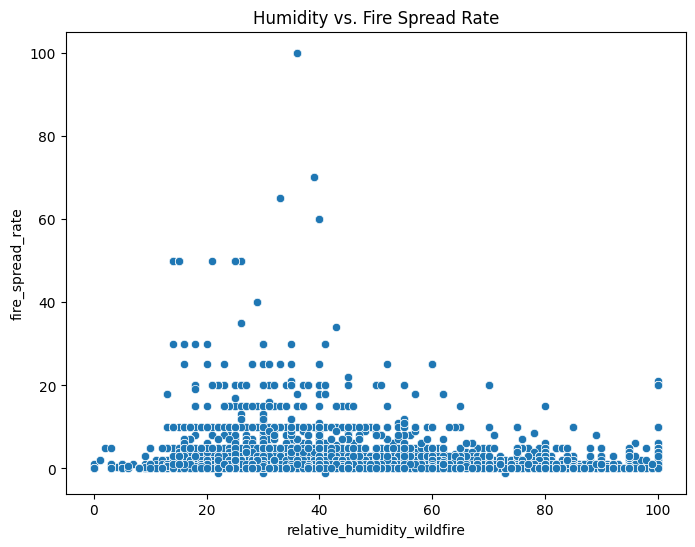

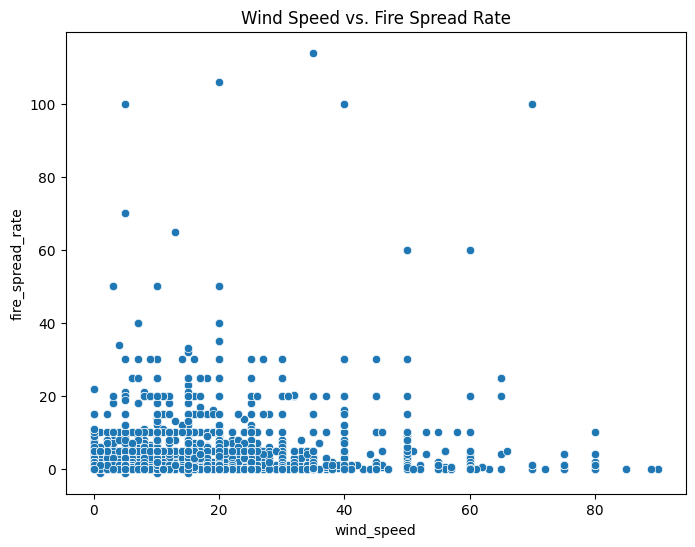

In [10]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function for creating boxplots to visualize outliers
def plot_boxplot(data, column, title):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f"Boxplot of {title}")
    plt.xlabel(column)
    plt.show()

# Visualize outliers for key numerical features
columns_to_check = ['assessment_size', 'fire_spread_rate', 'temperature', 'relative_humidity_wildfire', 'wind_speed']
for column in columns_to_check:
    plot_boxplot(merged_df, column, column)

# Visualize distributions
def plot_histogram(data, column, title):
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f"Distribution of {title}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

# Check distributions for the same key features
for column in columns_to_check:
    plot_histogram(merged_df, column, column)

# Scatterplots for feature relationships
def plot_scatter(data, x, y, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=x, y=y)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

# Key scatterplots to explore feature relationships
scatterplots = [
    ('temperature', 'assessment_size', 'Temperature vs. Fire Assessment Size'),
    ('relative_humidity_wildfire', 'fire_spread_rate', 'Humidity vs. Fire Spread Rate'),
    ('wind_speed', 'fire_spread_rate', 'Wind Speed vs. Fire Spread Rate')
]

for x, y, title in scatterplots:
    plot_scatter(merged_df, x, y, title)


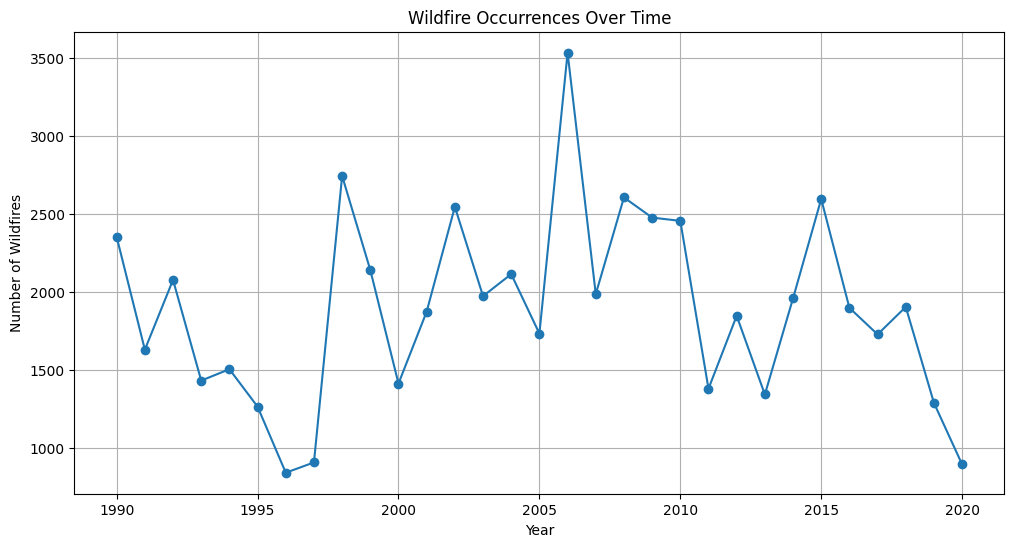

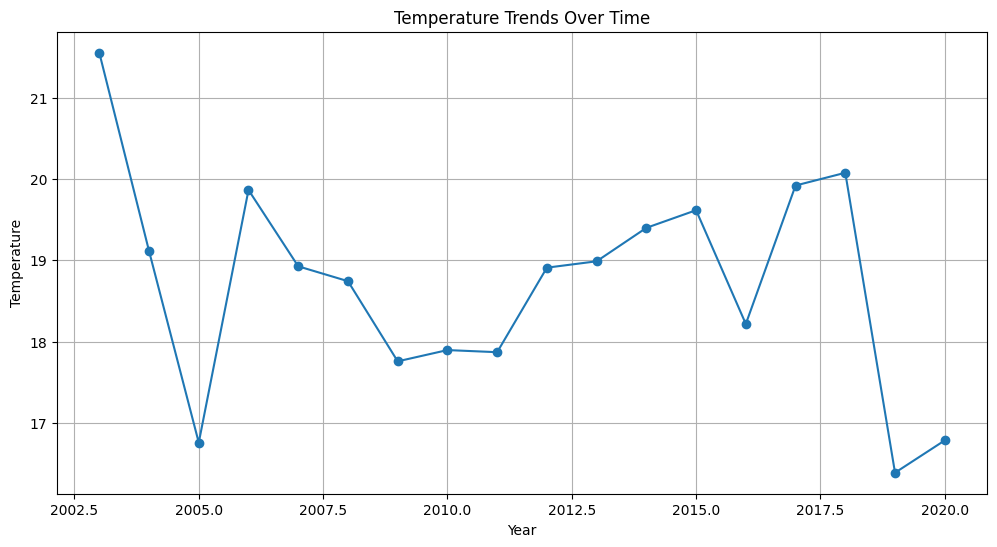

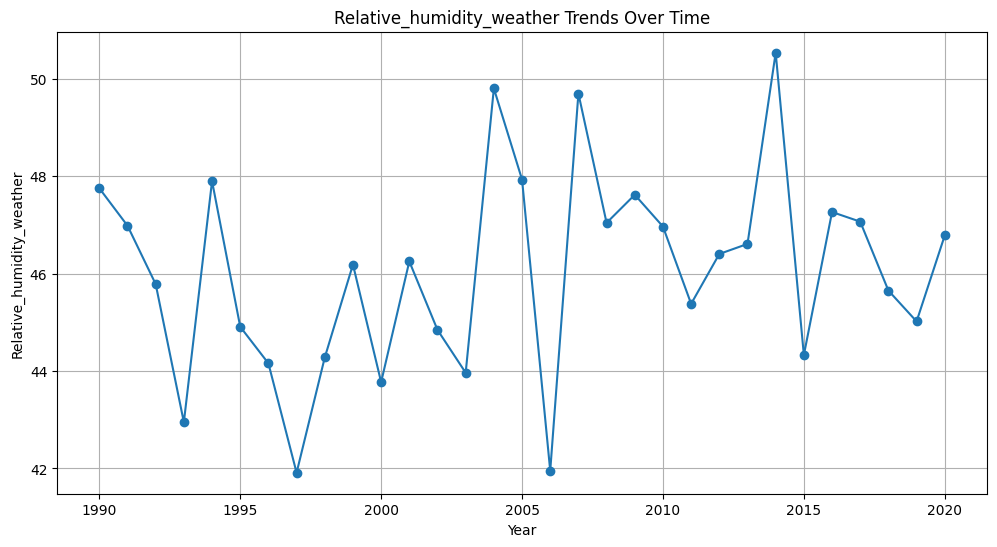

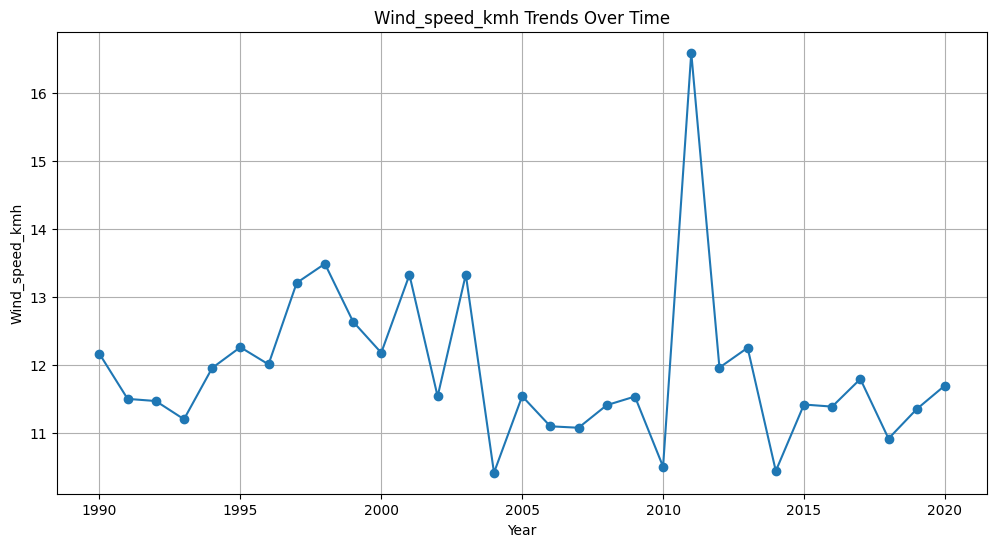

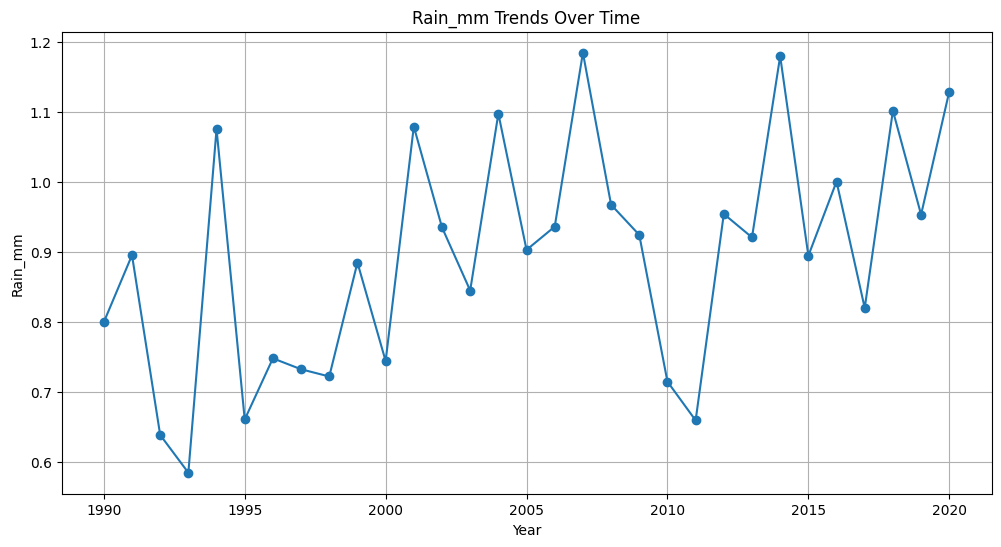

In [11]:
# Plot Wildfire Trends Over Time
plt.figure(figsize=(12, 6))
merged_df['date'].groupby(merged_df['date'].dt.year).count().plot(kind='line', marker='o')
plt.title("Wildfire Occurrences Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Wildfires")
plt.grid()
plt.show()

# Key Weather Variable Trends Over Time
weather_variables = ['temperature', 'relative_humidity_weather', 'wind_speed_kmh', 'rain_mm']
for var in weather_variables:
    plt.figure(figsize=(12, 6))
    merged_df[var].groupby(merged_df['date'].dt.year).mean().plot(kind='line', marker='o')
    plt.title(f"{var.capitalize()} Trends Over Time")
    plt.xlabel("Year")
    plt.ylabel(var.capitalize())
    plt.grid()
    plt.show()


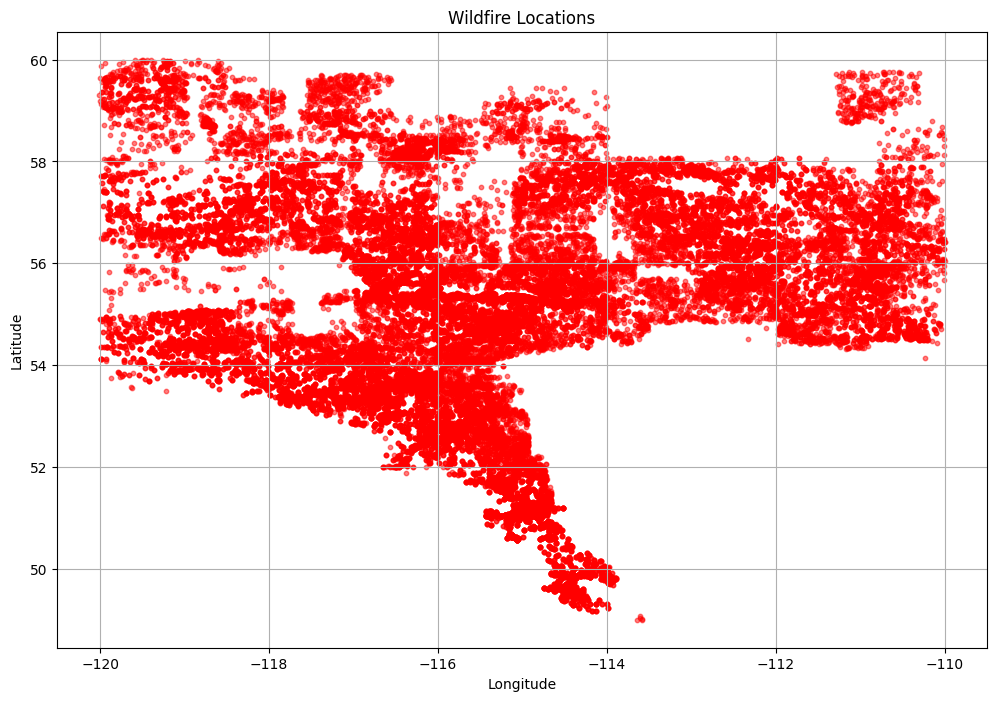

In [12]:
# Scatter Plot for Geospatial Data
plt.figure(figsize=(12, 8))
plt.scatter(merged_df['longitude_wildfire'], merged_df['latitude_wildfire'], alpha=0.5, s=10, c='red')
plt.title("Wildfire Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()


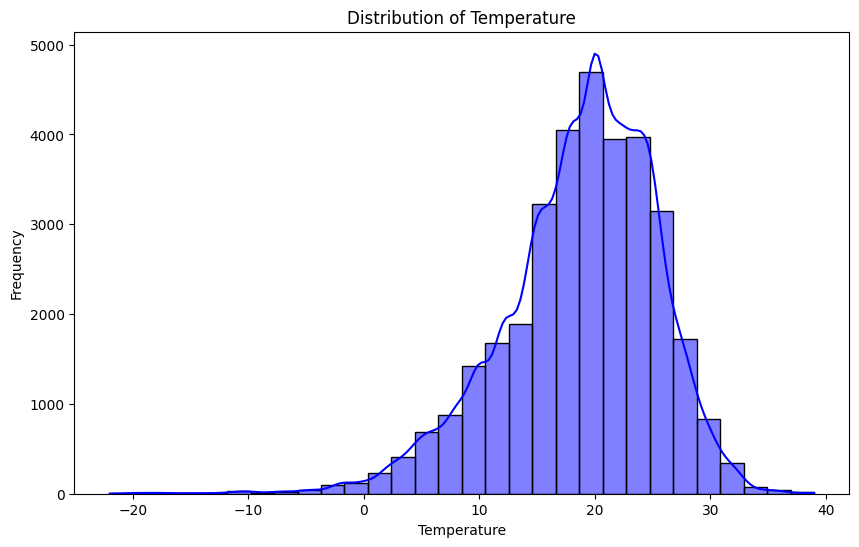

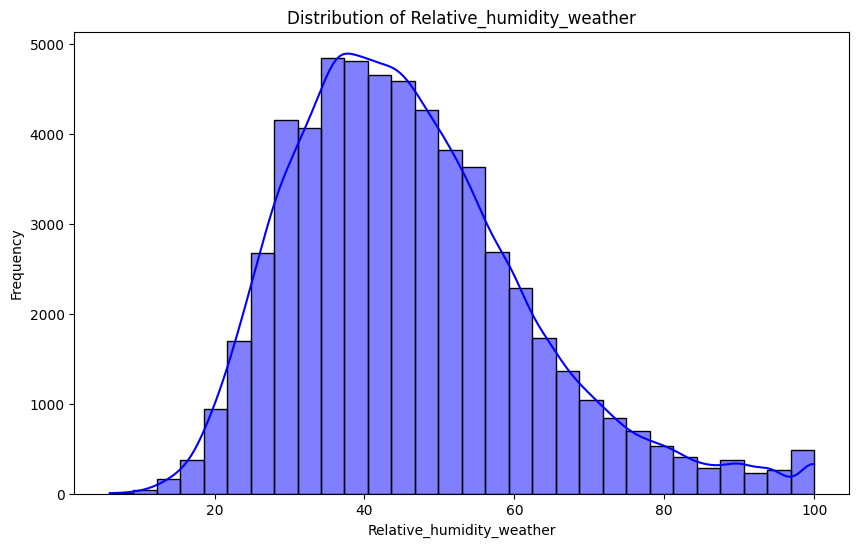

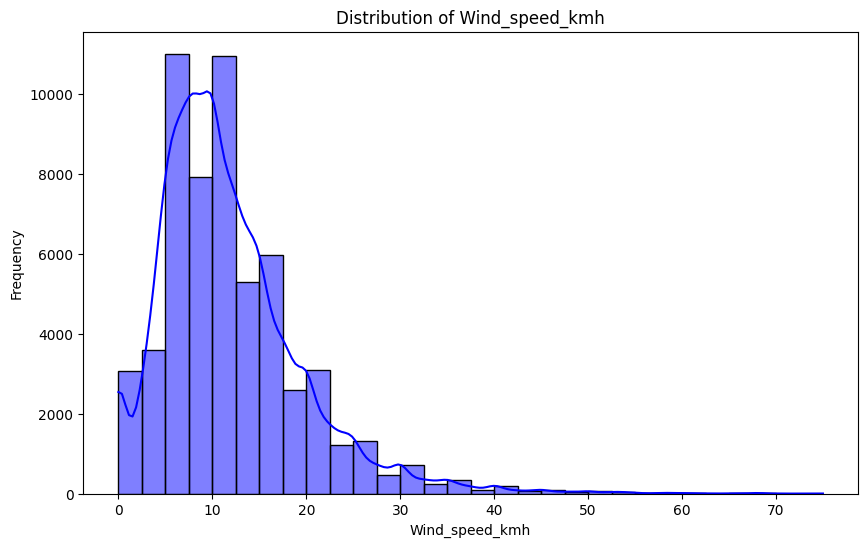

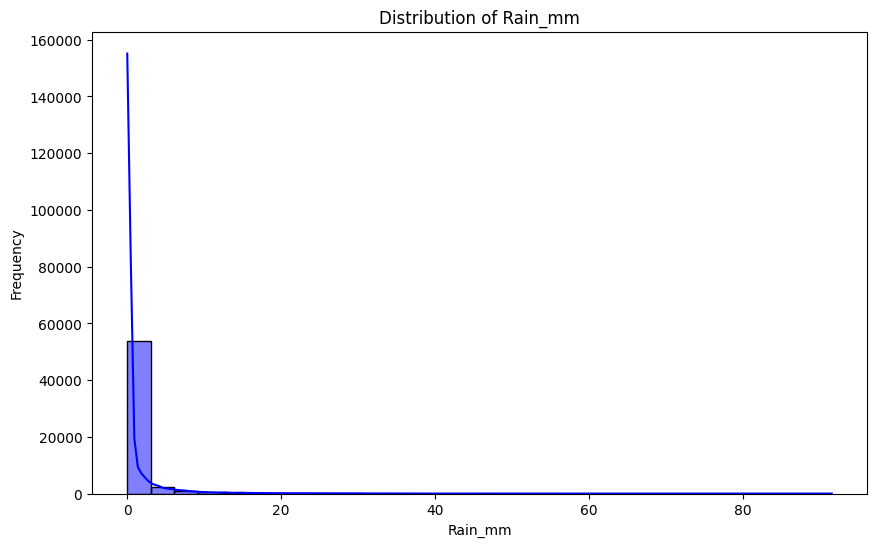

In [13]:
# Histograms for Key Weather Variables
weather_variables = ['temperature', 'relative_humidity_weather', 'wind_speed_kmh', 'rain_mm']
for var in weather_variables:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_df[var], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {var.capitalize()}")
    plt.xlabel(var.capitalize())
    plt.ylabel("Frequency")
    plt.show()


In [14]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np

# Create a copy of the dataset
df_features = merged_df.copy()

# Section 1: Time-based Features
df_features['year'] = df_features['date'].dt.year
df_features['month'] = df_features['date'].dt.month
df_features['day'] = df_features['date'].dt.day
df_features['season'] = df_features['month'].apply(lambda x: 'winter' if x in [12, 1, 2]
                                                   else 'spring' if x in [3, 4, 5]
                                                   else 'summer' if x in [6, 7, 8]
                                                   else 'fall')

# Optional: Encode season
season_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Updated parameter
season_encoded = season_encoder.fit_transform(df_features[['season']])
df_features = pd.concat([df_features, pd.DataFrame(season_encoded, columns=season_encoder.get_feature_names_out(['season']))], axis=1)

# Section 2: Weather Interactions
df_features['temp_wind_interaction'] = df_features['temperature'] * df_features['wind_speed_kmh']
df_features['temp_humidity_interaction'] = df_features['temperature'] * df_features['relative_humidity_weather']

# Rolling Averages
df_features['temp_3day_avg'] = df_features['temperature'].rolling(window=3).mean()
df_features['precip_3day_avg'] = df_features['rain_mm'].rolling(window=3).mean()

# Section 3: Geospatial Features
# Clustering latitude and longitude into zones (basic quantile-based binning as an example)
df_features['lat_bin'] = pd.qcut(df_features['latitude_wildfire'], q=4, labels=False)
df_features['lon_bin'] = pd.qcut(df_features['longitude_wildfire'], q=4, labels=False)

# Section 4: Categorical Encoding
# Encode fire_type
fire_type_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Updated parameter
fire_type_encoded = fire_type_encoder.fit_transform(df_features[['fire_type']])
df_features = pd.concat([df_features, pd.DataFrame(fire_type_encoded, columns=fire_type_encoder.get_feature_names_out(['fire_type']))], axis=1)

# Section 5: Normalization/Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_features[['temperature', 'wind_speed_kmh', 'assessment_size', 'fire_spread_rate']])
scaled_df = pd.DataFrame(scaled_features, columns=['temp_scaled', 'wind_speed_scaled', 'assessment_scaled', 'spread_rate_scaled'])
df_features = pd.concat([df_features, scaled_df], axis=1)

# Section 6: Handle Missing Values
# Example: Fill missing temperature with median
df_features['temperature'] = df_features['temperature'].fillna(df_features['temperature'].median())
df_features['relative_humidity_weather'] = df_features['relative_humidity_weather'].fillna(df_features['relative_humidity_weather'].median())

# Add binary indicator columns for missingness
for col in ['temperature', 'relative_humidity_weather']:
    df_features[f'{col}_missing'] = df_features[col].isnull().astype(int)

# Save engineered features to a new file for verification
df_features.to_csv('engineered_features.csv', index=False)

# Print feature summary
print("Feature Engineering Completed.")
print(df_features.info())
print(df_features.head())


Feature Engineering Completed.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58407 entries, 0 to 58406
Columns: 105 entries, Unnamed: 0 to relative_humidity_weather_missing
dtypes: datetime64[ns](2), float64(51), int32(3), int64(6), object(43)
memory usage: 46.1+ MB
None
   Unnamed: 0   id fire_number  year     discovered_date                date  \
0           0  103      E02001  1996 1996-05-04 13:12:00 1996-05-04 13:17:00   
1           0  103      E02001  1996 1996-05-04 13:12:00 1996-05-04 13:17:00   
2           2  573      W03016  1996 1996-06-27 14:35:00 1996-06-27 14:40:00   
3           2  573      W03016  1996 1996-06-27 14:35:00 1996-06-27 14:40:00   
4           3  574      W03017  1996 1996-06-27 15:20:00 1996-06-27 15:20:00   

  detection_agent_type smoke_type smoke_color smoke_base_size  ...  \
0                  LKT         HC          LG               N  ...   
1                  LKT         HC          LG               N  ...   
2                  LKT         LC